1. data (prepare and load)
2. build model
3. fitting the model to data (training)
4. making predictions
5. saving and loading a model
6. putting it all together

In [1]:
import torch
from torch import nn    # nn contains all of Pytorch's building blocks 
import matplotlib.pyplot as plt
torch.__version__

'2.0.1+cu118'

## 1. Data preparing and loading
Data can be almost anything in machine learning.
* Excel speadsheet
* Images of any kind
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:    
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representatioin.

To showcase this, let's create some known data using the linear regression formula.   
We'll use a linear regression formula to make a straight line with known parameters

In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [3]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

In [5]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
# Visualizing function
def plot_predictions(train_data = X_train, 
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    
    plt.figure(figsize = (10, 7))
    
    plt.scatter(train_data, train_labels, c = 'b', s = 4, label = 'Training data')
    plt.scatter(test_data, test_labels, c = 'g', s = 4, label = 'Testing data')
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c = 'r', s = 4, label = 'Predictions')
    
    plt.legend(prop = {'size': 14})

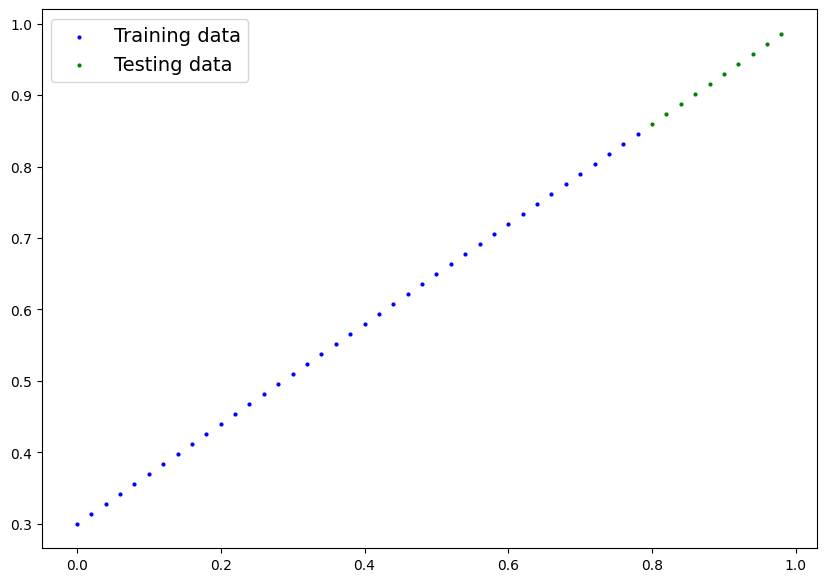

In [7]:
plot_predictions()

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent(or get closer to) the ideal values (the weight & bias values we used to create the data)   

Through two main algorithms:
1. Gradient descent
2. Backpropagation

### Pytorch model building essentials
Subclass `nn.Module` : this contains all the building blocks for neural networks.    
**Initialize model parameters** to be used in various computations. (these could be different layers from `torch.nn`, single parameters, hard-coded values or functions.)    
`requires_grad=True` means Pytorch will track the gradients of this specific parameter for use with `torch.autograd` and gradient descent.    
**Any subclass of nn.Module needs to override `forward()`**: this defines the forward computation of the model.

In [12]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad = True,    # Can this parameter be updated via gradient descent?
                                                dtype = torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad = True,
                                             dtype = torch.float))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias    # This is the regression formula

* `torch.nn`: contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* `torch.nn.Module`: The base class for all neural network modules, if you subclass it, you should overwrite forward()
* `torch.nn.Parameter`: what parameters should our model try and learn, often a pytorch layer from torch.nn will set these for us
* `torch.optim`: contains various optimization algorithms. these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss.
* `torch. utils.data.Dataset`: represents a map between key(label) and sample(features) pairs of your data.
* `torch. utils.data.DataLoader`: creates a Python iterable over a torch Dataset
* def forward() : All nn.Module suclasses require you to overwite forward(), this method defines what happens in the forward computation.

In [16]:
# Create a random seed: LinearRegressionModel class를 호출하면서 초기화되는 파라미터들을 고정함
# torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
print(model_0.parameters())
print(list(model_0.parameters()))

<generator object Module.parameters at 0x0000020CC5D486D0>
[Parameter containing:
tensor([0.2345], requires_grad=True), Parameter containing:
tensor([0.2303], requires_grad=True)]


In [17]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.2345])), ('bias', tensor([0.2303]))])

### Making prediction using `torch.inference_mode()`

In [18]:
# Making prediction using `torch.inference_mode()`: 모델을 업데이트하는 기능(ex.gradient tracking)을 모두 끔. 메모리에 저장되지 않음
with torch.inference_mode():
    y_preds = model_0(X_test)
    
# Similar with torch.no_grad(). but torch.inference_mode() is preferred
# with torch.no_grad():
#     y_preds = model_0(X_test)

In [21]:
y_preds    # no_grad

tensor([[0.4179],
        [0.4226],
        [0.4273],
        [0.4320],
        [0.4367],
        [0.4413],
        [0.4460],
        [0.4507],
        [0.4554],
        [0.4601]])

In [22]:
model_0(X_test)    # grad

tensor([[0.4179],
        [0.4226],
        [0.4273],
        [0.4320],
        [0.4367],
        [0.4413],
        [0.4460],
        [0.4507],
        [0.4554],
        [0.4601]], grad_fn=<AddBackward0>)

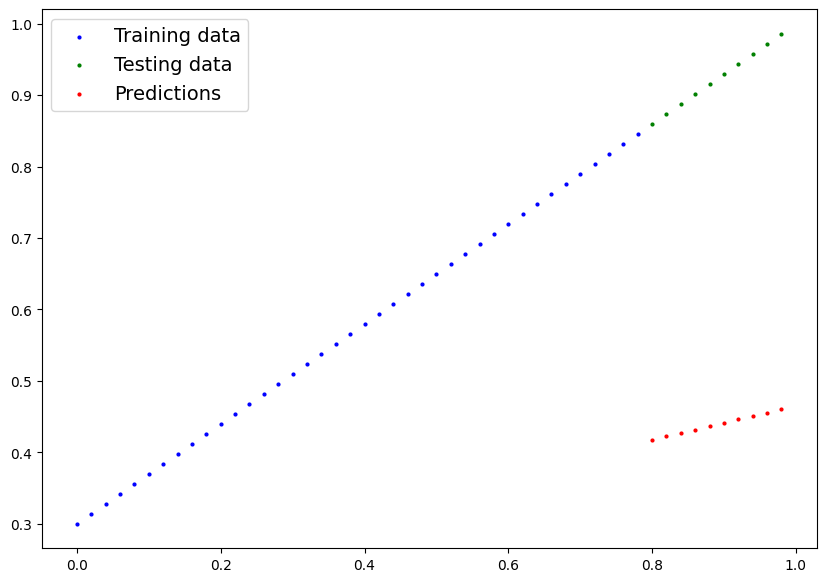

In [20]:
plot_predictions(predictions=y_preds)

### Train model

* **Loss function**: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters to improve the loss function.    
specifically for Pytorch, we need:
* A training loop
* A testing loop

### Building a training loop (and a testing loop) in pytorch

A couple of things we need is a training loop:    
1. Loop through the data and do..
2. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
3. Calculate the loss (compare forward pass predictions to ground truth labels)
4. Optimizer zero grad
5. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss(**gradient loss**)

In [26]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_0.parameters(),    # we want to optimize the parameters present in our model
                            lr = 0.01)

In [35]:
# An epoch is one loop through the data (this is a hyperparameter because we've set it ourselves)
epochs = 10

# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()    # train mode in pytorch sets all parameters to require gradients
    
    # 1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    print(loss)
    
    # 3. Optimizer zero grad (by default how the optimizer changes will accumulate)
    optimizer.zero_grad()
    
    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    
    # 5. Step the optimizer to update the model's parameters with respect to the gradients calcultaed by loss.backward()
    optimizer.step()    
    
    model_0.eval()    # turns off gradient tracking

tensor(0.2051, grad_fn=<MeanBackward0>)
tensor(0.1936, grad_fn=<MeanBackward0>)
tensor(0.1821, grad_fn=<MeanBackward0>)
tensor(0.1706, grad_fn=<MeanBackward0>)
tensor(0.1601, grad_fn=<MeanBackward0>)
tensor(0.1506, grad_fn=<MeanBackward0>)
tensor(0.1419, grad_fn=<MeanBackward0>)
tensor(0.1341, grad_fn=<MeanBackward0>)
tensor(0.1271, grad_fn=<MeanBackward0>)
tensor(0.1208, grad_fn=<MeanBackward0>)


In [28]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.2384])), ('bias', tensor([0.2403]))])

In [30]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.2423])), ('bias', tensor([0.2503]))])

In [32]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.2462])), ('bias', tensor([0.2603]))])

In [34]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.2501])), ('bias', tensor([0.2703]))])

In [36]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

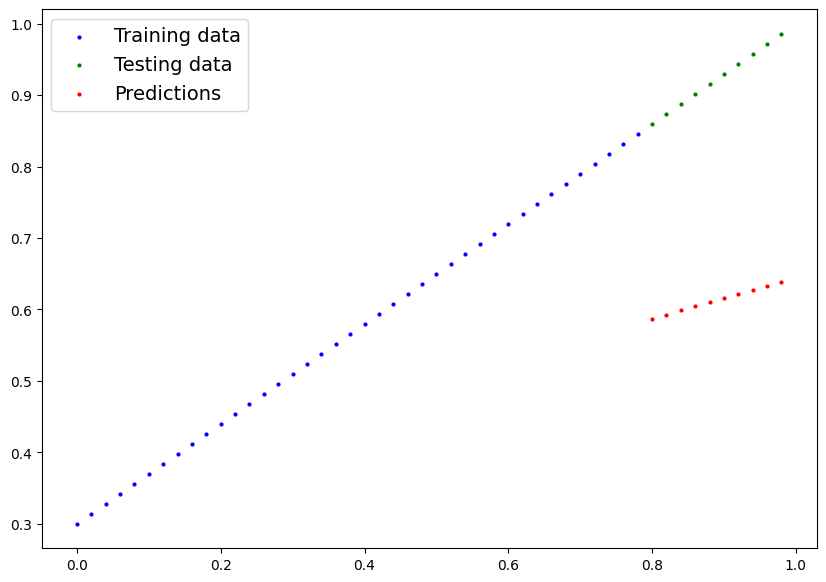

In [37]:
plot_predictions(predictions=y_preds_new)